In [1]:
import baryrat
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as lin
import pandas as pd
import seaborn as sns
import scipy.special as sps

import matrix_functions as mf
from zolotarev import tyler_inv_sqrt, tylers_sign

In [2]:
f = np.sqrt
a = 1
b = 100

# f = np.sign
# a = -1.
# b = 1.

Zolotarev found polynomials $p, q$ such that
$$r(x) = \frac{xp(x^2)}{q(x^2)} \approx \mathrm{sgn}(x)$$
on $x \in [-1, -\gamma] \cup [\gamma, 1]$ for $0 < \gamma < 1$.
Letting $s(x) = p(x) / q(x)$, this means
$$s(x^2) = \frac{r(x)}x \approx \frac{\mathrm{sgn}(x)}{x} = \frac1{|x|}$$
$$\implies |x| \approx \frac1{s(x^2)}$$
Letting $y = x^2$, this yields
$$\sqrt{y} \approx \frac1{s(y)} = \frac{q(y)}{p(y)}$$
for all $y \in [\gamma^2, 1]$.

The following shows the compares a low degree rational approximation to the real thing


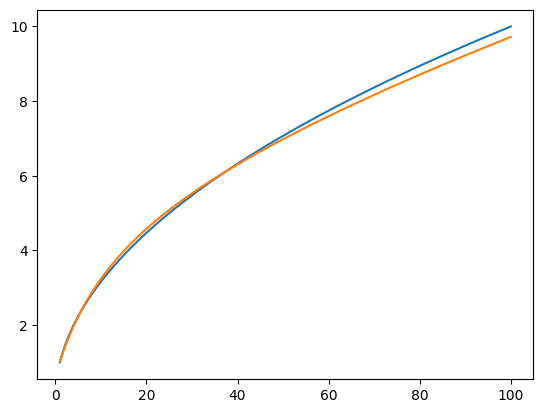

In [4]:
xxx = np.linspace(a, b, num=1000)
true = np.sqrt(xxx)
pred = 1/tyler_inv_sqrt(3, xxx.min(), xxx.max())(xxx)
plt.plot(xxx, true)
plt.plot(xxx, pred)

The following simple experiment shows our approximation converging to the real thing

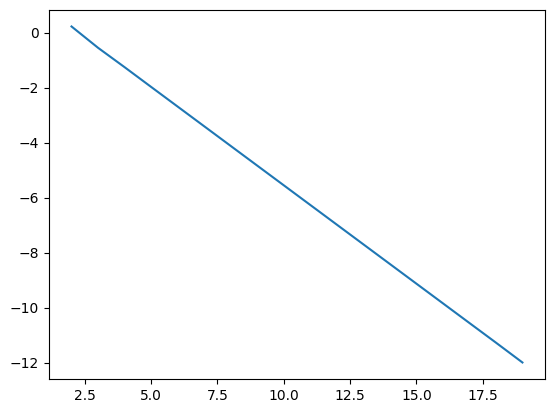

In [3]:
xxx = np.linspace(a, b, num=1000)

qq = list(range(2, 20))
error = []
for q in qq:
    # true = np.sign(xxx)
    # pred = tylers_sign(q, xxx.min(), xxx.max())(xxx)
    true = np.sqrt(xxx)
    pred = 1/tyler_inv_sqrt(q, xxx.min(), xxx.max())(xxx)
    error.append(np.linalg.norm(true - pred, ord=np.inf))

plt.plot(qq, np.log10(error))


But it isn't actually the $\ell^{\infty}$ minimizer, so the errors do not equioscillate

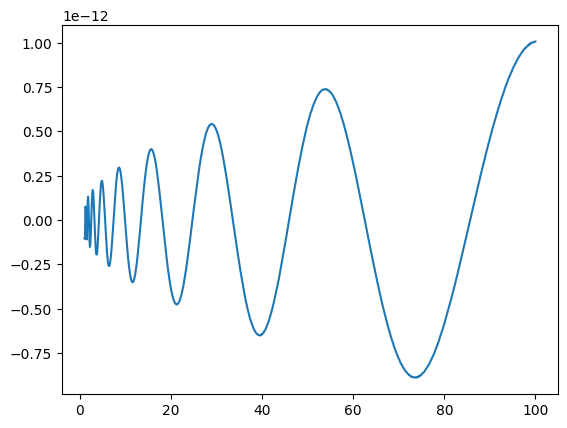

In [4]:
plt.plot(xxx, true-pred)
# plt.plot(xxx, np.log(np.abs(true-pred)))

In [5]:
dofs = []  # degrees of freedom
chebyshev_error = []
aaa_error = []
brasil_error = []
zolotarev_error = []

spectrum_discritization = np.linspace(a, b, 1000) # mf.cheb_nodes(1000, a, b) #
f_spectrum_discritization = f(spectrum_discritization)
for dof in range(4, 33, 2):
    cheb_interpolant = mf.cheb_interpolation(dof, f, a, b)
    dofs.append(dof)
    chebyshev_error.append(lin.norm(cheb_interpolant(spectrum_discritization) - f_spectrum_discritization, ord=np.inf))

    aaa_interpolant = baryrat.aaa(spectrum_discritization, f, mmax=(dof//2))
    aaa_error.append(lin.norm(aaa_interpolant(spectrum_discritization) - f_spectrum_discritization, ord=np.inf))

    # brasil_interpolant = baryrat.brasil(f, [a, b], (dof//2, dof//2))
    brasil_interpolant = baryrat.brasil(f, [a, b], (dof-3, 3))
    brasil_error.append(lin.norm(brasil_interpolant(spectrum_discritization) - f_spectrum_discritization, ord=np.inf))

    if f == np.sqrt: zolotarev_interpolant = lambda x: 1. / tyler_inv_sqrt(dof//2, a, b)(x)
    if f == np.sign: zolotarev_interpolant = tylers_sign(dof//2, a, b)
    zolotarev_error.append(lin.norm(zolotarev_interpolant(spectrum_discritization) - f_spectrum_discritization, ord=np.inf))

results = pd.DataFrame({
    "Degrees of Freedom": dofs,
    "Chebyshev": chebyshev_error,
    "AAA": aaa_error,
    "Brasil": brasil_error,
    "Zolotarev": zolotarev_error
})

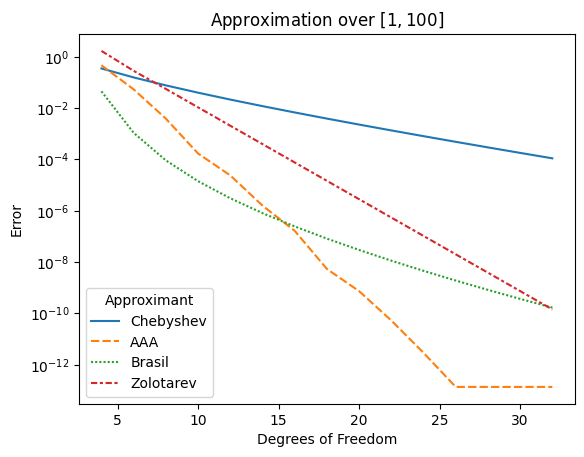

In [6]:
results_long = pd.melt(results, ["Degrees of Freedom"], value_name="Error", var_name="Approximant")
sns.lineplot(x="Degrees of Freedom", y="Error", hue="Approximant", style="Approximant", data=results_long).set(
    title=f'Approximation over $[{a}, {b}]$',
    yscale='log'
);